# Plotting Functions

## Imports

In [2]:
import os
import sys

sys.path.append('../scripts/')

plots_folder_path = '../plots'

In [3]:
import glob
from datetime import datetime, timedelta
from tqdm.notebook import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import networkx as nx

from system_fns import ArticleEntityAnalysis
from system_fns import (
    average_weighted_clustering_coefficient,
    average_centrality_metrics
)

## Data Loading

In [4]:
df = pd.read_csv('../data/business_w_topics.csv')
df = df[['date', 'id', 'unique_entities', 'topic']]
df['date'] = pd.to_datetime(pd.to_datetime(df['date']).dt.date)
df['unique_entities'] = [eval(l) for l in df['unique_entities']]
df = df.sort_values('date')

topic_label_map = dict(zip(
    df.topic.unique().tolist(),
    [
        'Infra and Transpo\nDevelopments',
        'Global Markets',
        'Trade Dynamics',
        'Corporate Affairs',
        'Economic Challenges',
        'Debt',
        'Regulatory Challenges'
        
        # 'Russia-Ukraine War', 'Global Market', 'PH GDP',
        # 'UK Budget Unemployment', 'Inflation', 'Others',
        # 'PH Marcos Jr.'
    ]
))

df.topic = df.topic.replace(topic_label_map)
df.head()

,date,id,unique_entities,topic
816,2023-01-01,2191765,"[Jaime Bautista, Bongbong Marcos, Manuel Tamay...",Infra and Transpo\nDevelopments
815,2023-01-02,2191867,"[Manny Pangilinan, Jaime Bautista]",Infra and Transpo\nDevelopments
814,2023-01-02,2192002,"[Jaime Bautista, Rodrigo Duterte, Manuel Tamay...",Infra and Transpo\nDevelopments
811,2023-01-03,2192961,"[Bongbong Marcos, Rodrigo Duterte]",Global Markets
813,2023-01-03,2192645,"[Ben Lee, Alidad Tash]",Global Markets


In [5]:
news_network = ArticleEntityAnalysis(df)

entity_projection = news_network.convert_to_projection(kind='entity')
article_projection = news_network.convert_to_projection(kind='article')

## Plots

### Bipartite Network

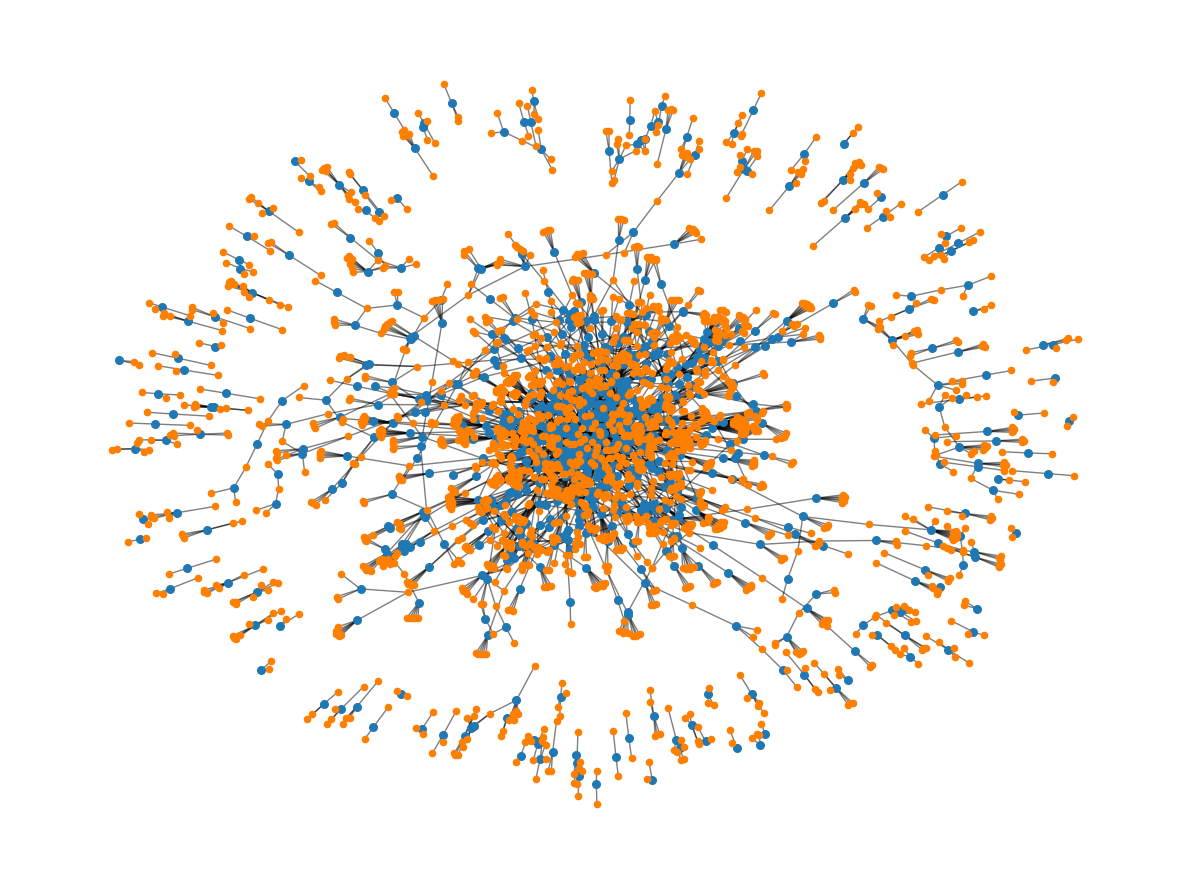

In [6]:
def plot_bipartite_network(B):
    """
    """
    global plots_folder_path
    article_nodes = [
        n for n, d in B.nodes(data=True) if d['bipartite']=='article'
    ]
    entity_nodes = [
        n for n, d in B.nodes(data=True) if d['bipartite']=='entity'
    ]
    
    plt.figure(figsize=(12, 9))

    pos = nx.spring_layout(
        B, k=0.030, seed=34
    )
    
    nx.draw_networkx_nodes(
        B, pos, nodelist=article_nodes, node_color='#1f78b4', node_size=30
    )
    nx.draw_networkx_nodes(
        B, pos, nodelist=entity_nodes, node_color='#ff7f00', node_size=20,
        # alpha=0.7
    )
    nx.draw_networkx_edges(B, pos, width=1, alpha=0.5)

    # nx.draw_networkx_labels(B, pos, font_size=12, font_family='sans-serif')

    plt.axis('off')
    plt.tight_layout()
    
    plt.savefig(
        os.path.join(plots_folder_path, 'bipartite_graph.png'),
        dpi=200,
        bbox_inches='tight'
    )

plot_bipartite_network(news_network.B)

### Entity Network

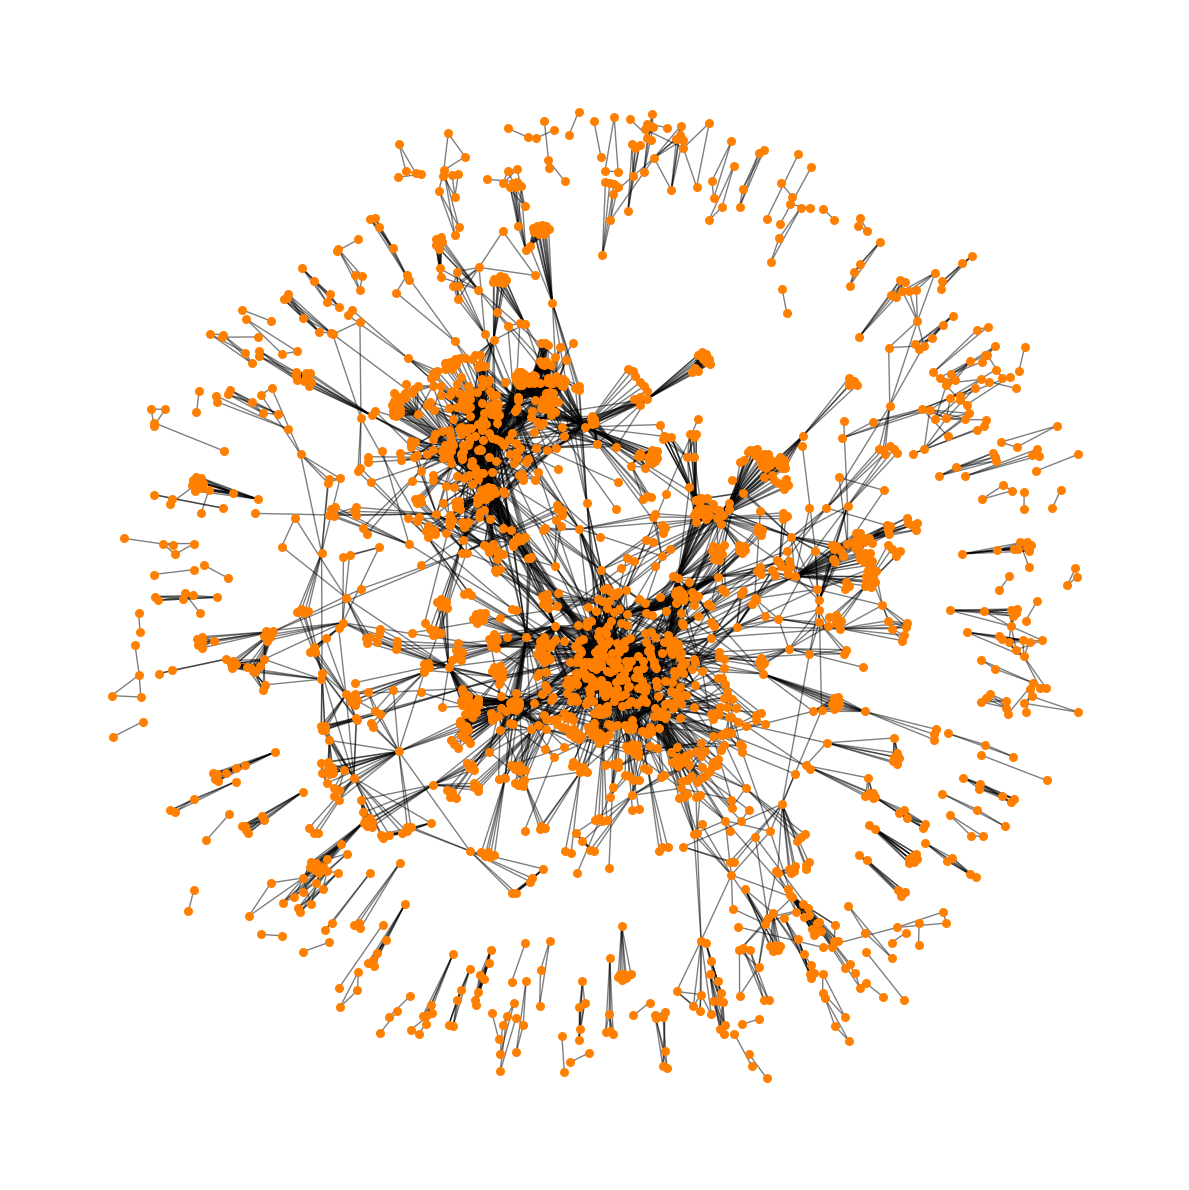

In [7]:
def plot_entity_network(entity_projection):
    """
    """
    plt.figure(figsize=(12, 12))

    pos = nx.spring_layout(entity_projection, k=0.07,
                        seed=34)

    nx.draw_networkx_nodes(entity_projection, pos, node_color='#ff7f00',
                        node_size=30)
    nx.draw_networkx_edges(entity_projection, pos, alpha=0.5)

    # nx.draw_networkx_labels(entity_projection, pos, font_size=10,
    #                         font_family='sans-serif')

    # plt.title("Entity Projection Graph")
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(
        os.path.join(plots_folder_path, 'entity_network.png'),
        dpi=200,
        bbox_inches='tight'
    )

plot_entity_network(entity_projection)

### Article Network

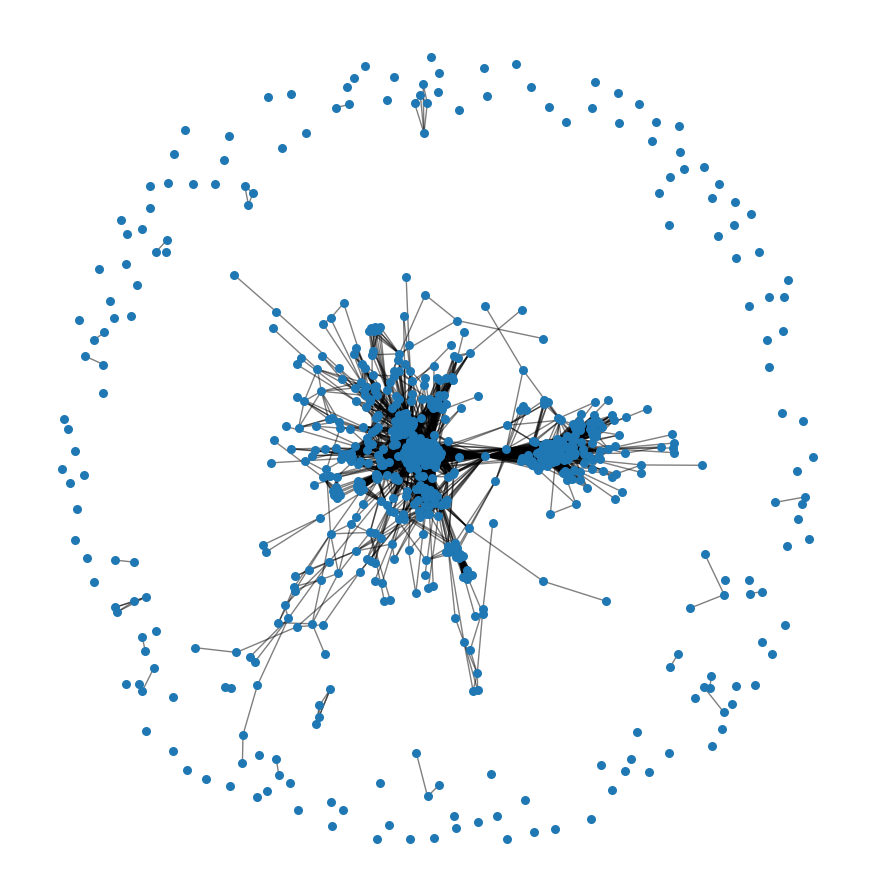

In [8]:
def plot_article_network(article_projection):
    plt.figure(figsize=(9, 9))
    
    pos = nx.spring_layout(article_projection, k=0.09,
                       seed=34)

    nx.draw_networkx_nodes(article_projection, pos, node_color='#1f78b4',
                        node_size=30)
    nx.draw_networkx_edges(article_projection, pos, alpha=0.5)
    
    # nx.draw_networkx_labels(article_projection, pos, font_size=10,
    #                         font_family='sans-serif')

    # plt.title("Article Projection Graph")
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(
        os.path.join(plots_folder_path, 'article_network.png'),
        dpi=200,
        bbox_inches='tight'
    )

plot_article_network(article_projection)

### Top Entities Bar Chart

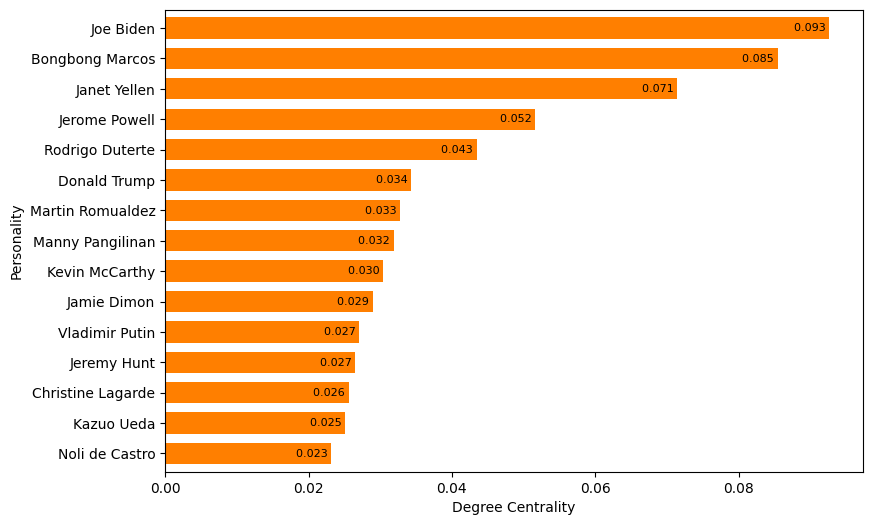

In [9]:
def plot_top_entities_bar_chart(entity_projection, p=15):
    """
    """
    sorted_degree_centrality = sorted(
        nx.degree_centrality(entity_projection).items(),
        key=lambda item: item[1],
        reverse=True
    )

    top_p_degree_centrality = sorted_degree_centrality[:p]

    df_top_p_degree_centrality = pd.DataFrame(
        top_p_degree_centrality,
        columns=['Node', 'Degree Centrality']
    )

    plt.figure(figsize=(9, 6))
    ax = (
        df_top_p_degree_centrality
        .set_index('Node')
        .squeeze()
        .sort_values()
        .plot.barh(width=0.70, color='#ff7f00')
    )
    
    for index, value in enumerate(
        df_top_p_degree_centrality['Degree Centrality']
        .sort_values(ascending=True)
    ):
        ax.text(
            value, index, f'{value:.3f} ',
            fontsize=8, va='center', ha='right'
        )
    # for bar in ax.containers:
    #     ax.bar_label(bar, fmt='%.3f', label_type='edge', fontsize=9)
    
    plt.xlabel('Degree Centrality')
    plt.ylabel('Personality')
    plt.savefig(
        os.path.join(plots_folder_path, 'top-entities-bar-chart.png'),
        dpi=200,
        bbox_inches='tight'
    )

plot_top_entities_bar_chart(entity_projection)

### Top Topics by Number of Articles

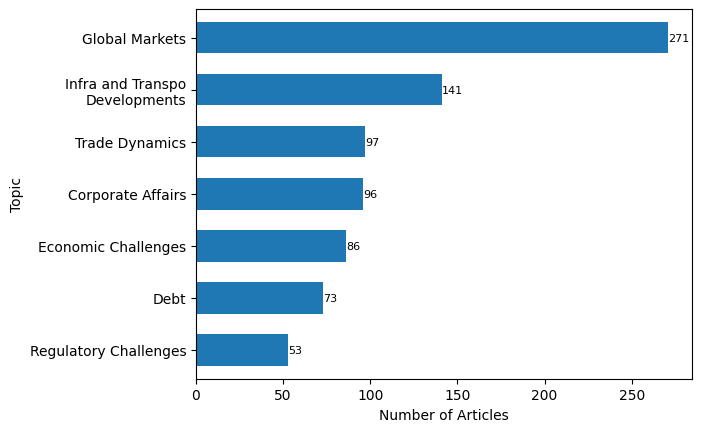

In [10]:
def plot_top_topics_by_num_articles(df):
    """
    """
    df_grouped = df.groupby('topic').size().sort_values()

    fig, ax = plt.subplots(figsize=(6.4, 4.8))
    bars = df_grouped.plot.barh(width=0.60, color='#1f78b4', ax=ax)

    for bar in bars.containers:
        ax.bar_label(bar, fmt='%d', label_type='edge', fontsize=8)

    plt.xlabel('Number of Articles')
    plt.ylabel('Topic')
    plt.savefig(
        os.path.join(plots_folder_path, 'topics-bar-chart-by-articles.png'),
        dpi=200,
        bbox_inches='tight'
    )

plot_top_topics_by_num_articles(df)

### Top Topics by Number of Unique Entities

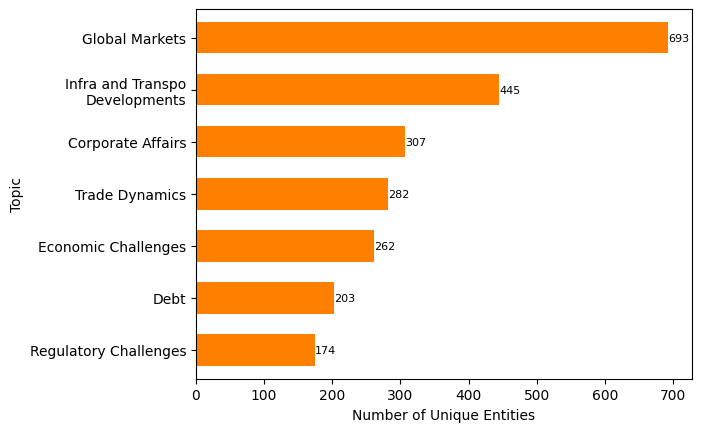

In [11]:
def plot_top_topics_by_num_unique_entities(df):
    """
    """
    df_explode = df.explode('unique_entities')
    df_grouped = (
        df_explode.groupby('topic').unique_entities.nunique().sort_values()
    )

    fig, ax = plt.subplots(figsize=(6.4, 4.8))
    bars = df_grouped.plot.barh(width=0.60, color='#ff7f00', ax=ax)

    for bar in bars.containers:
        ax.bar_label(bar, fmt='%d', label_type='edge', fontsize=8)

    plt.xlabel('Number of Unique Entities')
    plt.ylabel('Topic')
    plt.savefig(
        os.path.join(plots_folder_path,
                     'topics-bar-chart-by-unique-entities.png'),
        dpi=200,
        bbox_inches='tight'
    )

plot_top_topics_by_num_unique_entities(df)

### Topic Network

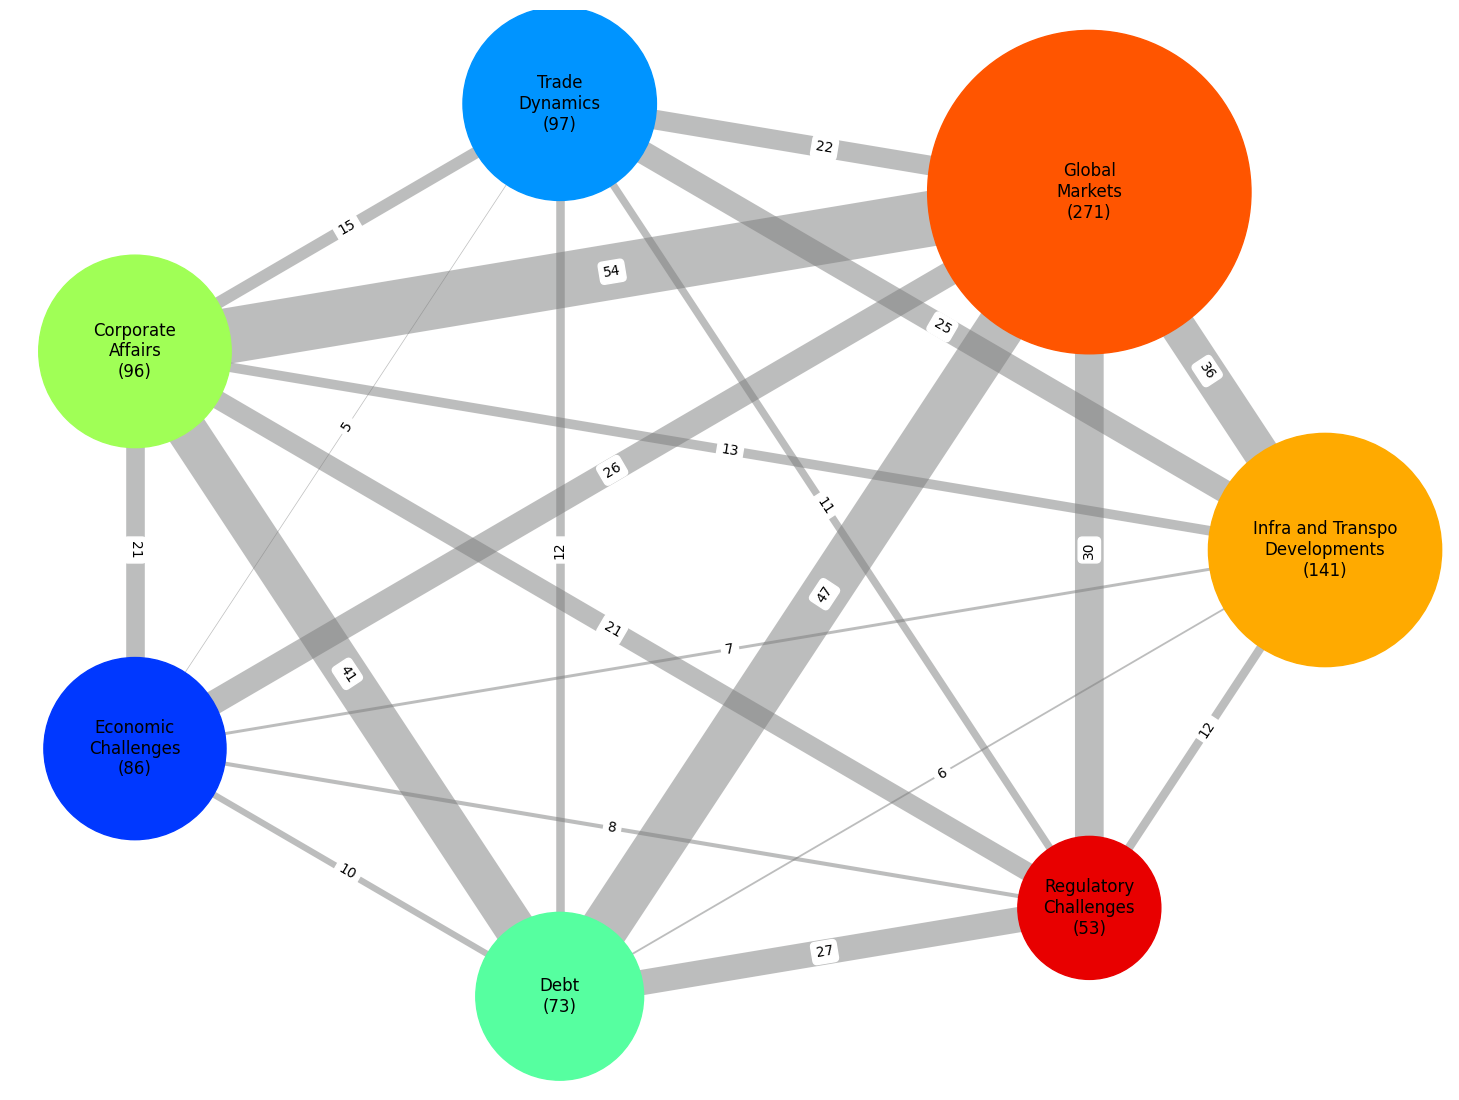

In [12]:
def create_topic_network(df):
    """
    """
    _nodes = df['topic'].unique()

    _edges = []
    for i in range(len(_nodes)):
        for j in range(i+1, len(_nodes)):
            topic1 = _nodes[i]
            topic2 = _nodes[j]
            entities_topic1 = list(set(
                [e for sublist in
                df[df['topic'] == topic1]['unique_entities']
                for e in sublist]
            ))
            entities_topic2 = list(set(
                [e for sublist in
                df[df['topic'] == topic2]['unique_entities']
                for e in sublist]
            ))
            
            common_entities = len(
                set(entities_topic1).intersection(entities_topic2)
            )
            
            if common_entities > 0:
                _edges.append((topic1, topic2, common_entities))

    # edges_df = pd.DataFrame(_edges, columns=['topic1', 'topic2',
    #                                          'shared_entities_count'])

    G = nx.Graph()

    G.add_nodes_from(_nodes)
    G.add_weighted_edges_from(_edges)
    
    return G

def plot_topic_network(df):
    """
    """
    color_map = {
        'Infra and Transpo\nDevelopments': '#ffaa00',
        'Global Markets': '#ff5500',
        'Trade Dynamics': '#0094ff',
        'Corporate Affairs': '#a0ff56',
        'Economic Challenges': '#0038ff',
        'Regulatory Challenges': '#e80000',
        'Debt': '#56ffa0'
    }

    G = create_topic_network(df)
    
    node_colors = [color_map[node] for node in G.nodes()]
    edge_weights = [G[u][v]['weight'] for u, v in G.edges()]
    node_sizes = [df[df['topic'] == node].shape[0]*200 for node in G.nodes()]

    # Set the visual scale of the edges via weights
    min_weight = min(edge_weights)
    max_weight = max(edge_weights)

    min_scale = 0.5
    max_scale = 40

    scaled_weights = [
        (w - min_weight)/(max_weight - min_weight)*(max_scale - min_scale) +
        min_scale
        for w in edge_weights
    ]

    # Modify label to include article count
    labels = {}
    for node in G.nodes():
        article_count = df[df['topic'] == node].shape[0]
        if len(node.split()) == 2:
            new_node = node.replace(' ', '\n')
            labels[node] = f"{new_node}\n({article_count})"
        else:
            new_node = node.replace('o D', 'O\nD')
            labels[node] = f"{new_node}\n({article_count})"

    # Draw the graph
    plt.figure(figsize=(12*1.2, 9*1.2))
    pos = nx.circular_layout(G)
    nx.draw(
        G, pos, with_labels=True, labels=labels, node_color=node_colors,
        edge_color=(0.4823, 0.4862, 0.4862, 0.5),
        width=scaled_weights, node_size=node_sizes, font_size=12
    )
    # plt.title("Topic Network")
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    # plt.tight_layout()
    plt.savefig(
        os.path.join(plots_folder_path,
                     'topic-network.png'),
        dpi=200,
        bbox_inches='tight'
    )

plot_topic_network(df)

### Top Entities Timeline

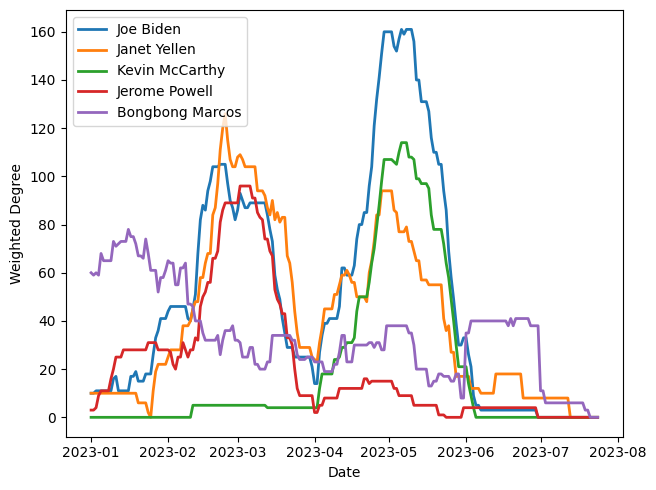

In [16]:
def plot_top_entities_timeline(self, p=5, window_size=7):
    """
    """
    current_date = self.start_date
    
    results = {}        
    while current_date <= self.end_date:
        cut = self.df[
            (self.df['date'] >= current_date) &
            (self.df['date'] <
                    current_date + pd.Timedelta(days=window_size))
        ]
        bipartite = self._create_bipartite_network(df=cut)
        projection = self.convert_to_projection(B=bipartite, kind='entity')

        if projection:
            weighted_degree_dict = dict(projection.degree(weight='weight'))
            for value, degree in weighted_degree_dict.items():
                if value not in results:
                    results[value] = []
                results[value].append((pd.Timestamp(current_date), degree))
        else:
            pass

        current_date += timedelta(1)
        
    all_dates = pd.date_range(self.start_date, self.end_date)
    for value in results:
        existing_dates = {date for date, _ in results[value]}
        missing_dates = set(all_dates) - existing_dates
        for missing_date in missing_dates:
            results[value].append((pd.Timestamp(missing_date), 0))
        results[value].sort()
    
    max_degree_elems = sorted(results,
                                key=lambda x: max([degree for _, degree in
                                                    results[x]]),
                                reverse=True)
    top_p_elems = max_degree_elems[:p]

    plt.figure(figsize=(12/1.8, 9/1.8))

    default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    color_dict = {value: color for value, color in
                    zip(top_p_elems, default_colors)}
    
    for index, focus_elem in enumerate(top_p_elems):
        values = results[focus_elem]
        dates, degrees = zip(*values)
        plt.plot(dates, degrees, '-', label=focus_elem,
                    color=color_dict[focus_elem], linewidth=2)
    plt.ylabel("Weighted Degree")
    plt.xlabel("Date")
    plt.legend(loc='upper left')
    # plt.title(f"Weighted Degree Progression of Top {p} Elements")
    plt.tight_layout()
    plt.savefig(
        os.path.join(plots_folder_path,
                     f'top-entities-timeline-{window_size}days.png'),
        dpi=200,
        bbox_inches='tight'
    )

plot_top_entities_timeline(news_network, 5, 30)

### Article Topic Timeline by Number of Articles

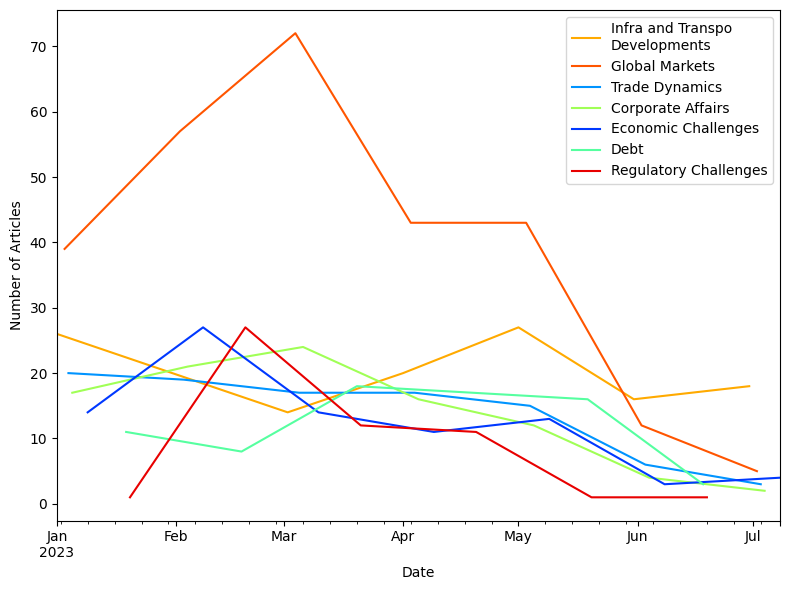

In [14]:
def plot_topics_timeline_by_num_articles(self, window_size=7):
    """
    """
    topics = self.df.topic.unique().tolist()
    
    current_date = self.start_date
    
    results = {topic: {} for topic in topics}
    while current_date <= self.end_date:
        cut = self.df[
            (self.df['date'] >= current_date) &
            (self.df['date'] <
                    current_date + pd.Timedelta(days=window_size))
        ]
        
        for topic in topics:
            topic_ts = (
                self.df[self.df.topic == topic]
                .set_index('date')
                .resample(f'{window_size}D')
                .size()
            )

            results[topic].update(topic_ts.to_dict())

        current_date += timedelta(1)

    color_map = {
        'Infra and Transpo\nDevelopments': '#ffaa00',
        'Global Markets': '#ff5500',
        'Trade Dynamics': '#0094ff',
        'Corporate Affairs': '#a0ff56',
        'Economic Challenges': '#0038ff',
        'Regulatory Challenges': '#e80000',
        'Debt': '#56ffa0'
    }
    
    plt.figure(figsize=(12/1.5, 9/1.5))
    for topic in topics:
        pd.Series(results[topic]).plot(color=color_map[topic], label=topic)
        # plt.plot(results[topic].keys(), results[topic].values(),
        #         color=color_map[topic], label=topic)
    plt.legend()
    plt.xlabel('Date')
    plt.ylabel('Number of Articles')
    plt.tight_layout()
    plt.savefig(
        os.path.join(plots_folder_path,
                     f'topics-timeline-{window_size}days.png'),
        dpi=200,
        bbox_inches='tight'
    )

plot_topics_timeline_by_num_articles(news_network, 30)

### Article Topic Timeline by Number of Unique Entities

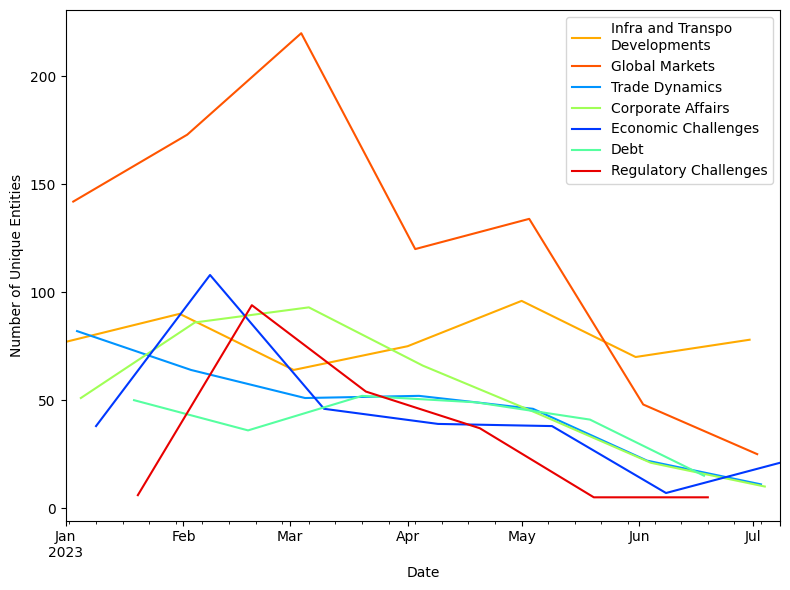

In [15]:
def plot_topics_timeline_by_num_unique_entities(self, window_size=7):
    """
    """
    topics = self.df.topic.unique().tolist()
    
    current_date = self.start_date
    
    df_explode = self.df.explode('unique_entities')
    
    results = {topic: {} for topic in topics}
    while current_date <= self.end_date:
        cut = self.df[
            (self.df['date'] >= current_date) &
            (self.df['date'] <
                    current_date + pd.Timedelta(days=window_size))
        ]

        for topic in topics:
            topic_ts = (
                df_explode[df_explode.topic == topic]
                .set_index('date')
                .resample(f'{window_size}D')
                ['unique_entities']
                .nunique()
            )

            results[topic].update(topic_ts.to_dict())

        current_date += timedelta(1)

    color_map = {
        'Infra and Transpo\nDevelopments': '#ffaa00',
        'Global Markets': '#ff5500',
        'Trade Dynamics': '#0094ff',
        'Corporate Affairs': '#a0ff56',
        'Economic Challenges': '#0038ff',
        'Regulatory Challenges': '#e80000',
        'Debt': '#56ffa0'
    }
    
    plt.figure(figsize=(12/1.5, 9/1.5))
    for topic in topics:
        pd.Series(results[topic]).plot(color=color_map[topic], label=topic)
        # plt.plot(results[topic].keys(), results[topic].values(),
        #         color=color_map[topic], label=topic)
    plt.legend()
    plt.xlabel('Date')
    plt.ylabel('Number of Unique Entities')
    plt.tight_layout()
    plt.savefig(
        os.path.join(plots_folder_path,
                     'topics-timeline-by-unique-entities-'
                      f'{window_size}days.png'),
        dpi=200,
        bbox_inches='tight'
    )

plot_topics_timeline_by_num_unique_entities(news_network, 30)